In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition,InjectedState
from langchain_core.messages import (
    HumanMessage,
    ToolMessage,
    
)
from langgraph.types import Command
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools.base import InjectedToolCallId


from typing_extensions import TypedDict
from typing import Annotated

#get graph visuals
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
import os
from dotenv import load_dotenv 




import datetime
import os.path

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

load_dotenv()
GOOGLE_API_KEY=os.getenv('google_api_key')

In [2]:
GEMINI_MODEL='gemini-2.0-flash'
llm = ChatGoogleGenerativeAI(google_api_key=GOOGLE_API_KEY, model=GEMINI_MODEL, temperature=0.3)

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    calendar: dict

In [4]:




if os.path.exists("token.json"):
    creds = Credentials.from_authorized_user_file("token.json")


try:
    service = build("calendar", "v3", credentials=creds)

    # # Call the Calendar API
    # now = datetime.datetime.now().isoformat() + "Z"  # 'Z' indicates UTC time
    # print("Getting the upcoming 10 events")
    # events_result = (
    #     service.events()
    #     .list(
    #         calendarId="primary",
    #         timeMin=now,
    #         maxResults=10,
    #         singleEvents=True,
    #         orderBy="startTime",
    #     )
    #     .execute()
    # )
    # events = events_result.get("items", [])

    # if not events:
    #     print("No upcoming events found.")
      
    # # Prints the start and name of the next 10 events
    # for event in events:
    #     start = event["start"].get("dateTime", event["start"].get("date"))
    #     print(start, event["summary"])

except HttpError as error:
    print(f"An error occurred: {error}")


In [5]:
# Call the Calendar API
def get_events_node(state: State):
    now = datetime.datetime.now().isoformat() + "Z"  # 'Z' indicates UTC time

    events_result = (
        service.events()
        .list(
            calendarId="primary",
            timeMin=now,
            maxResults=20,
            singleEvents=True,
            orderBy="startTime",
        )
        .execute()
    )
    events = events_result.get("items", [])
    ev={}
    for e in events:
        try:
            id= e.get('id')
            summary=e.get('summary')
            creator=e.get('creator')
            start=e.get("start").get("dateTime", e.get("start").get("date"))
            end=e.get("end").get("dateTime", e.get("end").get("date"))
            ev[start]={'summary':summary,
                    'creator':creator,
                    'start':start,
                    'end':end,
                        'event_id':id}
        except: ev[start]=e

    return Command(update={'calendar':ev,
                           })
    

    

In [6]:
@tool()
def creating_event(tool_call_id: Annotated[str, InjectedToolCallId],summary: str, location:str, description: str, start_time: str, end_time: str, timezone:str, recurrence: str):
    
  """
  Tool to create more complex events with a detailed description and optionnal recurrence.
  args: 
    summary: str = Field(description='the title of the event')
    location: str = Field(description='the address or location of the event')
    description: str = Field(description='the description of the event')
    start_time: str = Field(description=='the start time of an event, has to be formatted as such: eg. 2015-05-28T09:00:00-07:00')
    end_time: str = Field(description=='the end time of an event, has to be formatted as such: eg. 2015-05-28T09:00:00-07:00')
    timezone: str = Field(description='The timezone of the event (Formatted as an IANA Time Zone Database name, e.g. "Europe/Zurich".)')
    recurrence: str = Field(description='to defice the recurrence of the event(DAILY, WEEKLY, MONTHLY, YEARLY), follow this format eg. RRULE:FREQ=DAILY;COUNT=2')
  If an argument is not mentionned, simply input an empty string eg. ''.
  """
  event = {
  'summary': summary,
  'location': location,
  'description': description,
  'start': {
    'dateTime': start_time,
    'timeZone': timezone,
  },
  'end': {
    'dateTime': end_time,
    'timeZone': timezone,
  },
  'recurrence': [
    recurrence
  ],
  'reminders': {
    'useDefault': False,
    'overrides': [
      {'method': 'email', 'minutes': 24 * 60},
      {'method': 'popup', 'minutes': 10},
    ],
  },
}
  try:
    event = service.events().insert(calendarId='primary', body=event).execute()
    return Command(goto='get_events',
                   update={'messages':[ ToolMessage('succesfully created the event', tool_call_id=tool_call_id)]})
  except: 
    return Command(update={'messages':[ ToolMessage('failed to create the event', tool_call_id=tool_call_id)]})
  

In [7]:
@tool
def quick_add_event(event_description:str,tool_call_id: Annotated[str, InjectedToolCallId]):
    """
    tool to create a quick event
    args: event_description - a description of the event, including the start and end time (eg. 'Appointment at Somewhere on June 3rd 10am-10:25am' )
    """
    try:
        created_event = service.events().quickAdd(
        calendarId='primary',
        text=event_description).execute()
        return Command(goto='get_events',
                       update={'messages':[ ToolMessage('succesfully created the event', tool_call_id=tool_call_id)]})
    except: 
        return Command(update={'messages':[ ToolMessage('failed to create the event', tool_call_id=tool_call_id)]})

In [8]:
@tool
def get_calendar(state: Annotated[dict, InjectedState],tool_call_id: Annotated[str, InjectedToolCallId]):
    """
    tool to get the calendar to answer questions
    args: none
    """

    try:
        calendar=state['calendar']
        return Command(update={'messages':[ ToolMessage(str(calendar), tool_call_id=tool_call_id)]})
    except:
        now = datetime.datetime.now().isoformat() + "Z"  # 'Z' indicates UTC time

        events_result = (
            service.events()
            .list(
                calendarId="primary",
                timeMin=now,
                maxResults=20,
                singleEvents=True,
                orderBy="startTime",
            )
            .execute()
        )
        events = events_result.get("items", [])
        ev={}
        for e in events:
            try:
                id= e.get('id')
                summary=e.get('summary')
                creator=e.get('creator')
                start=e.get("start").get("dateTime", e.get("start").get("date"))
                end=e.get("end").get("dateTime", e.get("end").get("date"))
                ev[start]={'summary':summary,
                        'creator':creator,
                        'start':start,
                        'end':end,
                            'event_id':id}
            except:
                    ev[start]=e

        return Command(update={'calendar':ev,
             'messages':[ToolMessage(str(ev), tool_call_id=tool_call_id)]})

In [ ]:
@tool
def update_calendar(tool_call_id: Annotated[str, InjectedToolCallId]):
    """
    tool to return the latest version of the calendar
    agrs: none
    """
    now = datetime.datetime.now().isoformat() + "Z"  # 'Z' indicates UTC time

    events_result = (
        service.events()
        .list(
            calendarId="primary",
            timeMin=now,
            maxResults=20,
            singleEvents=True,
            orderBy="startTime",
        )
        .execute()
    )
    events = events_result.get("items", [])
    ev={}
    for e in events:
        try:
            id= e.get('id')
            summary=e.get('summary')
            creator=e.get('creator')
            start=e.get("start").get("dateTime", e.get("start").get("date"))
            end=e.get("end").get("dateTime", e.get("end").get("date"))
            ev[start]={'summary':summary,
                    'creator':creator,
                    'start':start,
                    'end':end,
                        'event_id':id}
        except:
                ev[start]=e

    return Command(update={'calendar':ev,
        'messages':[ToolMessage('updated calendar', tool_call_id=tool_call_id)]})

In [10]:
class Calendar_agent:
    def __init__(self):
        self.agent=self._setup()
    def _setup(self):
   
        langgraph_tools=[quick_add_event,get_calendar,creating_event,update_calendar]



        graph_builder = StateGraph(State)

        # Modification: tell the LLM which tools it can call
        llm_with_tools = llm.bind_tools(langgraph_tools)
        tool_node = ToolNode(tools=langgraph_tools)
        def chatbot(state: State):
            """ travel assistant that answers user questions about their trip.
            Depending on the request, leverage which tools to use if necessary."""
            return {"messages": [llm_with_tools.invoke(state['messages'])]}

        graph_builder.add_node("chatbot", chatbot)

        graph_builder.add_node('get_events',get_events_node)
        graph_builder.add_node("tools", tool_node)
        # Any time a tool is called, we return to the chatbot to decide the next step
        graph_builder.add_edge(START,'chatbot')
        graph_builder.add_edge("tools", "chatbot")
        graph_builder.add_conditional_edges(
            "chatbot",
            tools_condition,
        )
        memory=MemorySaver()
        graph=graph_builder.compile(checkpointer=memory)
        return graph
        

    def display_graph(self):
        return display(
                        Image(
                                self.agent.get_graph().draw_mermaid_png(
                                    draw_method=MermaidDrawMethod.API,
                                )
                            )
                        )
    def stream(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        input_message = HumanMessage(content=input)
        for event in self.agent.stream({"messages": [input_message]}, config, stream_mode="values"):
            event["messages"][-1].pretty_print()

    def chat(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        response=self.agent.invoke({'messages':HumanMessage(content=str(input))},config)
        return response['messages'][-1].content
    
    def get_state(self, state_val:str):
        config = {"configurable": {"thread_id": "1"}}
        return self.agent.get_state(config).values[state_val]

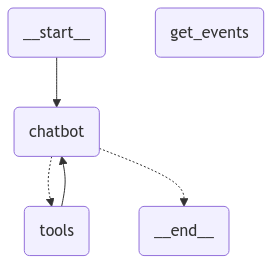

In [11]:
agent=Calendar_agent()
agent.display_graph()

In [12]:
agent.stream('get calendar')

================================ Human Message =================================

get calendar
================================== Ai Message ==================================
Tool Calls:
  get_calendar (8a18cd03-c2a3-426b-8ede-c3b2424dc2a8)
 Call ID: 8a18cd03-c2a3-426b-8ede-c3b2424dc2a8
  Args:
================================= Tool Message =================================
Name: get_calendar

{'2025-09-07T11:00:00-04:00': {'summary': 'Titouan: Festival, ile de re', 'creator': {'email': 'padioutristan@gmail.com', 'self': True}, 'start': '2025-09-07T11:00:00-04:00', 'end': '2025-09-07T12:00:00-04:00', 'event_id': '3gj9pktuojrdda1rks7uf4b3sh'}, '2025-12-14': {'summary': 'Loanne birthday', 'creator': {'email': 'padioutristan@gmail.com', 'self': True}, 'start': '2025-12-14', 'end': '2025-12-15', 'event_id': '3fvhjh0t8sh2ffpa3otg772q3k_20251214'}, '2025-12-21': {'summary': 'Anna birthday', 'creator': {'email': 'padioutristan@gmail.com', 'self': True}, 'start': '2025-12-21', 'end': '2025-12

In [14]:
agent.get_state('calendar')

{'2025-09-07T11:00:00-04:00': {'summary': 'Titouan: Festival, ile de re',
  'creator': {'email': 'padioutristan@gmail.com', 'self': True},
  'start': '2025-09-07T11:00:00-04:00',
  'end': '2025-09-07T12:00:00-04:00',
  'event_id': '3gj9pktuojrdda1rks7uf4b3sh'},
 '2025-12-14': {'summary': 'Loanne birthday',
  'creator': {'email': 'padioutristan@gmail.com', 'self': True},
  'start': '2025-12-14',
  'end': '2025-12-15',
  'event_id': '3fvhjh0t8sh2ffpa3otg772q3k_20251214'},
 '2025-12-21': {'summary': 'Anna birthday',
  'creator': {'email': 'padioutristan@gmail.com', 'self': True},
  'start': '2025-12-21',
  'end': '2025-12-22',
  'event_id': '07grgqniiemg5fkqrqv5a168jg_20251221'},
 '2026-01-01': {'summary': "Test Contact's birthday",
  'creator': {'email': 'padioutristan@gmail.com', 'self': True},
  'start': '2026-01-01',
  'end': '2026-01-02',
  'event_id': 'kcsjjqrbmstrf1a4ovg5p4gjvo_20260101'},
 '2026-12-14': {'summary': 'Loanne birthday',
  'creator': {'email': 'padioutristan@gmail.com